# Import modules

In [1]:
import sys #to use files in git_repos folder
sys.path.insert(0,'../')
from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
import atlite
import xarray as xr
import logging
import cdsapi
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.io import shapereader
import cartopy.crs as ccrs
import numpy as np
from atlite.datasets.era5 import _rename_and_clean_coords
import pandas as pd
logging.basicConfig(level=logging.INFO)
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Retrieve cutout

In [5]:
GCM = 'EC-Earth3' #'MPI-ESM1-2-LR'
ssp =  'ssp585' # 'ssp370'
variant_label = 'r4i1p1f1' #'r11i1p1f1' 

esgf_params = {
   'data_node': 'esgf-cnr.hpc.cineca.it',
   'source_id': GCM,
   'variant_label':variant_label,
   'experiment_id': ssp,
   'project' : 'CMIP6',
   'frequency':['3hr','6hr','day','mon'],
    }

year = '2032'
dt='3H'
cutout_cmip = atlite.Cutout(path='cmip_' + GCM + '_europe_2031.nc', 
                            module=['cmip'],
                            x=slice(-13,45), # European region
                            y=slice(32,72), # European region
                            time=year + '-01',
                            esgf_params=esgf_params,
                            dt=dt, 
                            dx=1, 
                            dy=1)

In [ ]:
cutout_cmip.prepare(features=['wind', 'influx', 'temperature', 'runoff'])

In [6]:
cutout_cmip.prepare()
cutout_cmip.data

Several frequencies requested - searching for ua100m at a frequencies of ['3hr', '6hr', 'day', 'mon']
ua100m found at frequency of 6hr



-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


Several frequencies requested - searching for va100m at a frequencies of ['3hr', '6hr', 'day', 'mon']
va100m found at frequency of 6hr



-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


Several frequencies requested - searching for tas at a frequencies of ['3hr', '6hr', 'day', 'mon']
tas found at frequency of 3hr



-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


Several frequencies requested - searching for sfcWind at a frequencies of ['3hr', '6hr', 'day', 'mon']
sfcWind found at frequency of 3hr



-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


Several frequencies requested - searching for rsds at a frequencies of ['3hr', '6hr', 'day', 'mon']
rsds found at frequency of 3hr



-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


Several frequencies requested - searching for rsus at a frequencies of ['3hr', '6hr', 'day', 'mon']
rsus found at frequency of 3hr



-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


Several frequencies requested - searching for mrro at a frequencies of ['3hr', '6hr', 'day', 'mon']
mrro found at frequency of 3hr



-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


[########################################] | 100% Completed |  7min  9.6s


<xarray.Dataset>
Dimensions:      (x: 59, y: 41, time: 248)
Coordinates:
  * x            (x) int64 -13 -12 -11 -10 -9 -8 -7 -6 ... 39 40 41 42 43 44 45
  * y            (y) int64 32 33 34 35 36 37 38 39 ... 65 66 67 68 69 70 71 72
  * time         (time) datetime64[ns] 2032-01-01 ... 2032-01-31T21:00:00
    lon          (x) float64 dask.array<chunksize=(59,), meta=np.ndarray>
    lat          (y) float64 dask.array<chunksize=(41,), meta=np.ndarray>
Data variables:
    wnd10m       (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    influx       (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    outflux      (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    temperature  (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    runoff       (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    wnd100m      (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    wnd_azimuth  (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
Attributes: (12/55)
    module:                          cmip
    prepared_features:               ['wind', 'runoff', 'influx', 'temperatur...
    chunksize_time:                  100
    dt:                              3H
    dx:                              1
    dy:                              1
    ...                              ...
    tracking_id:                     hdl:21.14100/226c9fe6-a45e-4fbb-95b6-b73...
    history:                         2019-07-29T10:39:58Z ; CMOR rewrote data...
    DODS_EXTRA.Unlimited_Dimension:  time
    data_node:                       esgf-cnr.hpc.cineca.it
    project:                         CMIP6
    variable:                        sfcWind

In [10]:
cutout_cmip.data.coords

Coordinates:
  * x        (x) int64 -13 -12 -11 -10 -9 -8 -7 -6 ... 38 39 40 41 42 43 44 45
  * y        (y) int64 32 33 34 35 36 37 38 39 40 ... 64 65 66 67 68 69 70 71 72
  * time     (time) datetime64[ns] 2032-01-01 ... 2032-01-31T21:00:00
    lon      (x) float64 dask.array<chunksize=(59,), meta=np.ndarray>
    lat      (y) float64 dask.array<chunksize=(41,), meta=np.ndarray>

In [12]:
#%%
"""
2. Download geometry of Europan countries and join. 
This can later be used as shapes when converting the weather variables in the 
cutout to solar, wind and hydro power. 

"""
def natural_earth_shapes_EU(join_dict, drop_non_Europe=['MA','DZ','TN','GI']):
    # Download shape file (high resolution)
    shpfilename = shapereader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_1_states_provinces')
    
    df =gpd.read_file(shpfilename)
    df = df.cx[-13:32,35:80]
    df = df[['iso_a2','geometry']]
    df = df.dissolve('iso_a2')
    df.index = list(df.index)
    drop_regions = drop_non_Europe
    # Absorbe microstates
    for main_r,sub_rs in join_dict.items():
        temp_main = df.loc[main_r,'geometry']
        for sub_r in sub_rs:
            drop_regions.append(sub_r)
            temp_r = df.loc[sub_r,'geometry']
        
            temp_main = temp_main.union(temp_r)
        temp_main = gpd.GeoSeries([temp_main])
        df.loc[[main_r],'geometry'] = temp_main.values
    
    df = df.drop(index=drop_regions)
    return df

# Create Europe shapefile
join_dict = {'FR':['GG','AD','MC'],
             'IT':['VA','SM'], 
             'GB':['JE','IM'],
             'FI':['AX'],
             'DK':['FO'],
             'CH':['LI'], 
             'BE':['LU'],
             'RS':['XK']}
europe = natural_earth_shapes_EU(join_dict)

#%%%
"""
2b. Alternative to 2 in wich only the geometry of a country is loaded.
"""
#Define country and shapes
shpfilename = shapereader.natural_earth(resolution="10m", 
                                      category="cultural", 
                                      name="admin_0_countries")

reader = shapereader.Reader(shpfilename)

#country='Denmark'
Denmark = gpd.GeoSeries({r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},).reindex(["Denmark"])


In [30]:
retrieve_roughness = True

if retrieve_roughness:
    # Wind Capacity factor CMIP : the surface roughness is not available 
    # from the CMIP database so ERA5 roughness is used instead.
    # (ideally this step is removed and wind velocity is interpolated from the 
    # wind speed at two closest heights)
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'format': 'netcdf',
            'product_type': 'monthly_averaged_reanalysis',
            'variable': 'forecast_surface_roughness',
            'year': '2019',
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'area': [
                83, -13, 32,
                45,
            ],
            'time': '00:00',
        },
        'roughness.nc')
    # Create roughness data based on 1 year average from ERA5. 
    # Then interpolate the ERA5 data into the resolution of CMIP.
    roughness = xr.open_dataset('roughness.nc')
    roughness = roughness.rename({'fsr':'roughness'})
    roughness = roughness.mean(dim='time')
    roughness = _rename_and_clean_coords(roughness)
    roughness.roughness.attrs['prepared_feature'] = 'wind'
    da = roughness.roughness.interp_like(cutout_cmip.data['influx'].isel(time=0))
    cutout_cmip.data = cutout_cmip.data.assign(roughness=da)

2023-11-01 14:45:53,159 INFO Welcome to the CDS
INFO:cdsapi:Welcome to the CDS
2023-11-01 14:45:53,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-11-01 14:45:53,346 INFO Request is queued
INFO:cdsapi:Request is queued
2023-11-01 14:45:54,394 INFO Request is running
INFO:cdsapi:Request is running
2023-11-01 14:45:58,240 INFO Request is completed
INFO:cdsapi:Request is completed
2023-11-01 14:45:58,242 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data6/adaptor.mars.internal-1698846357.881893-26853-14-9e4efdcb-0f8e-4865-8056-b0b65c72fe8d.nc to roughness.nc (1.1M)
INFO:cdsapi:Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data6/adaptor.mars.internal-1698846357.881893-26853-14-9e4efdcb-0f8e-4865-8056-b0b65c72fe8d.

# Convert cutout into wind timeseries

Compare the wind timeseries based on 1) extrapolation of 10 m wind speed based on roughness and 2) interpolation of the wind speed between two heights

In [33]:
cp_wind_extrapolation = cutout_cmip.wind('Vestas_V112_3MW',
                                         "extrapolation",
                                         shapes=europe,
                                         capacity_factor=True,
                                         per_unit=True)

Calculating wind speed at hub height using 1 wind speed dataset and surface roughness dataset.


In [34]:
cp_wind_interpolation = cutout_cmip.wind('Vestas_V112_3MW', 
                                         "interpolation",
                                          shapes=europe,
                                          capacity_factor=True,
                                          per_unit=True)

Calculating wind speed at hub height using 2 wind speed datasets.


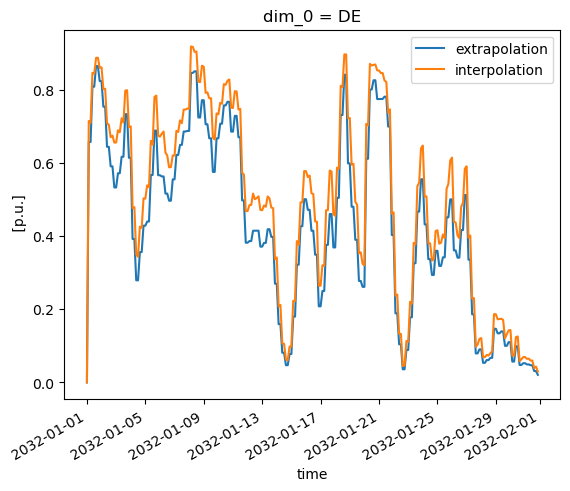

In [41]:
fig, ax = plt.subplots()
cp_wind_extrapolation.sel(dim_0='DE').plot(ax=ax, label="extrapolation")
cp_wind_interpolation.sel(dim_0='DE').plot(ax=ax, label="interpolation")
ax.legend()